# Offline reconstruction of pMRI data

In this notebook we study offline reconstruction algorithm for pMRI data.
Dependecies:
- this repository
- pysap-mri
- pysap
- modopt
and their dependencies
## Introduction

Typically, MRI reconstruction is done entirely after the full acquisition of the k-space data (so-called offline reconstruction)
During the acquisition sequence of MRI can be very long, and this dead time can be used to start the reconstruction.
### Offline vs Online

In the context of pMRI the problem is stated as follows for an (calibrationless) offline reconstruction
$$
\hat{x} = \arg\min \|\Omega \mathcal{F}x - y \| + g(\Psi x) \tag{Problem 1}
$$

where:
- $\mathcal{F}$ is the fourier transform operator
- $\Omega$ is the sampling mask, representing the acquisition by the MRI
- $y$ is the completly observed data in kspace.
- $\Psi$ is a sparsifying transform (typically a Wavelet transform)
- $g$ is a proximable regularisation operator ($\ell_1$, groupLasso, OWL...)

Solving this problem is done by using an iterative algorithm relying on convex Optimisation and gradient descent (Condat-Vu, POGM, FISTA...)


## Setup

- This notebook relies on the python packages modopt, pysap, pysap-mri and their dependences.
- As a toy model, let's consider a 2D pMRI acquisition with 16 channels where the k-space ( of size 640 x 320) is sampled along 80 columns.

In [1]:
%cd /home/pac/gits/phd/mri-online/

/home/pac/gits/phd/mri-online


In [2]:
import os
import time
import numpy as np
import copy
import matplotlib.pyplot as plt
import scipy as sp
from mri.operators import FFT, WaveletN, OWL
from online.operators.proximity import LASSO
from online.generators import KspaceGenerator
from online.reconstructors import OnlineReconstructor
from modopt.opt.proximity import GroupLASSO, IdentityProx
from modopt.opt.linear import Identity
from mri.reconstructors import CalibrationlessReconstructor
from mri.operators import GradAnalysis, GradSynthesis

from project_utils import implot, load_data, create_cartesian_metrics
from online.metrics import psnr_ssos, ssim_ssos, ssos

/home/pac/gits/phd/pysap-mri/mri/operators/fourier/non_cartesian.py:27: UserWarning: pynfft python package has not been found. If needed use the master release.
  warnings.warn("pynfft python package has not been found. If needed use "
/home/pac/gits/phd/pysap-mri/mri/operators/fourier/non_cartesian.py:42: UserWarning: gpuNUFFT python package has not been found. If needed please check on how to install in README
  warnings.warn("gpuNUFFT python package has not been found. If needed "


In [3]:
DATA_DIR = "data/"
RESULT_DIR = "data/results/"
N_JOBS = 1
results = dict()

16 (640, 320)


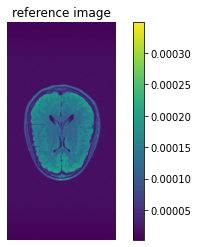

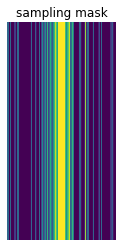

In [4]:
full_k, real_img, mask_loc, final_mask = load_data(DATA_DIR,2, monocoil=False,use_ref_kspace=True)
# use mono-coil data
# full_k = sp.fft.fftshift(sp.fft.fft2(real_img,norm="ortho"))
final_k = full_k * final_mask

real_img = ssos(sp.fft.ifftshift(sp.fft.ifft2(full_k,norm="ortho")))
implot(real_img, "reference image",colorbar=True)
if full_k.ndim == 2:
    implot(np.sqrt(np.abs(full_k)), "full kspace : first coil")
implot(final_mask, "sampling mask")
real_img_size = real_img.shape
square_mask= np.zeros(real_img.shape)
img_size = [min(real_img.shape)]*2
square_mask[real_img_size[0] // 2 - img_size[0] // 2:real_img_size[0] // 2 + img_size[0] // 2,
            real_img_size[1] // 2 - img_size[1] // 2:real_img_size[1] // 2 + img_size[1] // 2] = 1

K_DIM = final_mask.shape
N_COILS = 1 if full_k.ndim == 2 else full_k.shape[0]
print(N_COILS, K_DIM)

## naive direct inversion

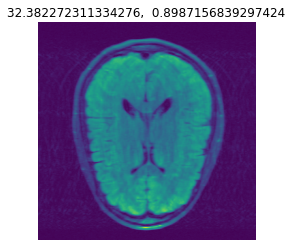

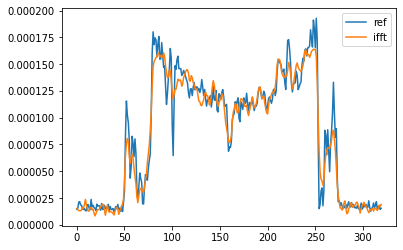

In [5]:
dirrec= sp.fft.ifftshift(sp.fft.ifft2(final_k,norm="ortho"))
implot(ssos(dirrec), title=f'{psnr_ssos(dirrec,real_img,mask=square_mask)},  {ssim_ssos(dirrec,real_img,mask=square_mask)}',mask=square_mask)

plt.figure()
plt.plot(abs(real_img[320]),label='ref')
plt.plot(ssos(dirrec)[320],label='ifft')
plt.legend()


## Condat + GL

In [6]:
fourier_op = FFT(mask=final_mask,
                 shape=K_DIM,
                 n_coils=N_COILS,
                 n_jobs=N_JOBS)

# Wavelets coefficients for each coils
linear_op = WaveletN("sym8", nb_scale=4, n_coils=N_COILS, n_jobs=-1)
# initialisation of wavelet transform
linear_op.op(np.zeros_like(final_k))

# Regularizer definition
if N_COILS ==1:
    GL_op = LASSO(weights=1e-6)
else:
    GL_op = GroupLASSO(weights=2e-6)
    
OWL_op = OWL(alpha=1e-05,
             beta=1e-12,
             bands_shape=linear_op.coeffs_shape,
             mode='band_based',
             n_coils=N_COILS,
             n_jobs=N_JOBS)


prox_op = GL_op
cost_op_kwargs={'cost_interval':1}
solver = CalibrationlessReconstructor(
        fourier_op,
        linear_op=linear_op,
        regularizer_op=prox_op,
        gradient_formulation="analysis",
        verbose=0)

metrics = {'psnr': {'metric': lambda test, ref, mask: psnr_ssos(test,ref),
                        'mapping': {'x_new': 'test'},
                        'early_stopping': False,
                        'cst_kwargs': {'ref': real_img,
                                       'mask': square_mask},
                        },
          'ssim': {'metric': lambda test, ref,mask: ssim_ssos(test,ref),
                        'mapping': {'x_new': 'test'},
                        'early_stopping': False,
                        'cst_kwargs': {'ref': real_img,
                                       'mask': square_mask},
                        }}
xf_condat, cost, metric_results_condatvu= solver.reconstruct(final_k,
                                                             optimization_alg='condatvu',
                                                             metrics=metrics,
                                                             metric_call_period=1,num_iterations=200
                                                        )


metric_results_condatvu['cost'] = {'index':np.arange(0,len(cost),cost_op_kwargs['cost_interval']),
                          'values':np.array(cost)}


100% (200 of 200) |######################| Elapsed Time: 0:06:58 Time:  0:06:58


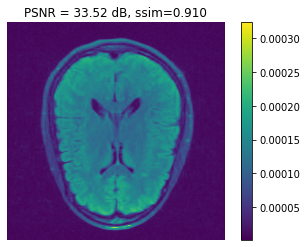

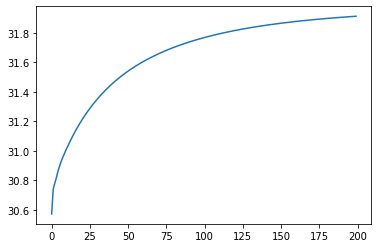

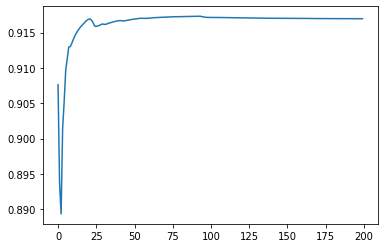

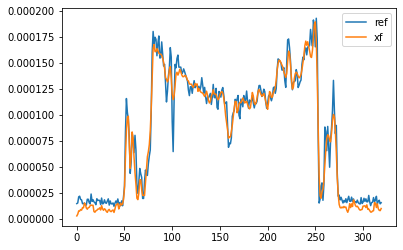

In [7]:
psnr = psnr_ssos(xf_condat,real_img,mask=square_mask)
ssim = ssim_ssos(xf_condat,real_img,mask=square_mask)

implot(ssos(xf_condat),title=f"PSNR = {psnr:.2f} dB, ssim={ssim:.3f}",mask=square_mask, colorbar=True)
fig,ax = plt.subplots()
ax.get_yaxis().get_major_formatter().set_useOffset(False)
ax.plot(metric_results_condatvu['psnr']['index'],metric_results_condatvu['psnr']['values'])
plt.figure()
plt.plot(metric_results_condatvu['ssim']['index'],metric_results_condatvu['ssim']['values'])

plt.figure()
plt.plot(abs(real_img[320]),label='ref')
plt.plot(ssos(xf_condat)[320],label='xf')
plt.legend()

### POGM + GL


In [8]:
prox_op=GL_op
# The fourier Operator apply also the sampling mask.
cost_op_kwargs={'cost_interval':1}
solver2 = CalibrationlessReconstructor(
        fourier_op,
        linear_op=linear_op,
        regularizer_op=prox_op,
        gradient_formulation="synthesis",
        verbose=0)


metrics = {'psnr': {'metric': lambda test, ref, mask: psnr_ssos(test,ref),
                        'mapping': {'x_new': 'test'},
                        'early_stopping': False,
                        'cst_kwargs': {'ref': real_img,
                                       'mask': square_mask},
                        },
          'ssim': {'metric': lambda test, ref,mask: ssim_ssos(test,ref),
                        'mapping': {'x_new': 'test'},
                        'early_stopping': False,
                        'cst_kwargs': {'ref': real_img,
                                       'mask': square_mask},
                        }}
xf_pogm, cost, metric_results_pogm = solver2.reconstruct(final_k, optimization_alg='pogm',metrics=metrics,
                                                             metric_call_period=1,num_iterations=200)

metric_results_pogm['cost'] = {'index':np.arange(0,len(cost),cost_op_kwargs['cost_interval']),
                          'values':np.array(cost)}

100% (200 of 200) |######################| Elapsed Time: 0:06:09 Time:  0:06:09


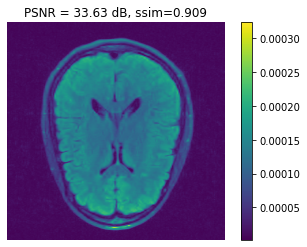

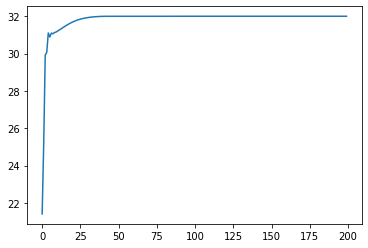

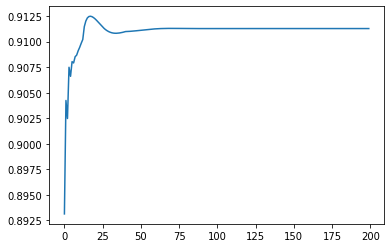

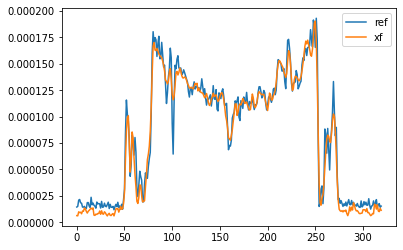

In [9]:
psnr = psnr_ssos(xf_pogm,real_img,mask=square_mask)
ssim = ssim_ssos(xf_pogm,real_img,mask=square_mask)

implot(ssos(xf_pogm),title=f"PSNR = {psnr:.2f} dB, ssim={ssim:.3f}",mask=square_mask, colorbar=True)
fig,ax = plt.subplots()
ax.get_yaxis().get_major_formatter().set_useOffset(False)
ax.plot(metric_results_pogm['psnr']['index'],metric_results_pogm['psnr']['values'])
plt.figure()
plt.plot(metric_results_pogm['ssim']['index'],metric_results_pogm['ssim']['values'])

plt.figure()
plt.plot(abs(real_img[320]),label='ref')
plt.plot(abs(ssos(xf_pogm)[320]),label='xf')
plt.legend()

In [11]:


kspace_gen= KspaceGenerator(full_kspace=final_k, mask=final_mask,max_iter=80)
full_k, real_img, mask_loc, final_mask = load_data(DATA_DIR, 2, monocoil=True)
final_k = np.squeeze(full_k * final_mask[np.newaxis])

K_DIM = kspace_gen.shape[-2:]
N_COILS = kspace_gen.shape[0] if full_k.ndim == 3 else 1
#line_fourier_op = ColumnFFT(shape=K_DIM, mask=final_mask, n_coils=N_COILS)

if N_COILS ==1:
    GL_op = LASSO(weights=2e-6)
else:
    GL_op = GroupLASSO(weights=2e-6/1000)
    

# The fourier Operator apply also the sampling mask.
cost_op_kwargs={'cost_interval':1}
online_pb = OnlineReconstructor(
        fourier_op,
        linear_op=Identity(),
        regularizer_op=IdentityProx(),
        opt='vanilla',
        verbose=0)

metrics_config = create_cartesian_metrics(online_pb, real_img, final_mask, final_k)

results = online_pb.reconstruct(kspace_gen,
                            eta=1.,
                           **metrics_config)

    

  0%|          | 0/80 [00:00<?, ?it/s]

vanilla


100%|██████████| 80/80 [01:58<00:00,  1.48s/it]


In [12]:
def plot_metric(results, name, log=False, ax=None):
    if ax == None:
        ax = plt.gca()
    if log:
        plt.semilogy(results['metrics'][name]['index'], results['metrics'][name]['values'],label=name)
    else:
        plt.plot(results['metrics'][name]['index'], results['metrics'][name]['values'],label=name)


In [13]:
x=ssos(results['x_final'])
psnr = psnr_ssos(x,real_img, mask=square_mask)
ssim = ssim_ssos(x, real_img, mask=square_mask)

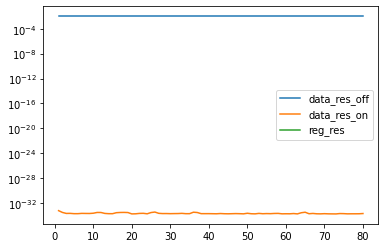

<Figure size 432x288 with 0 Axes>

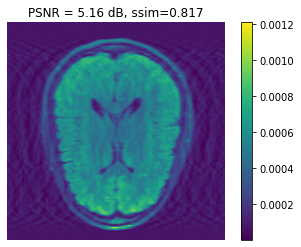

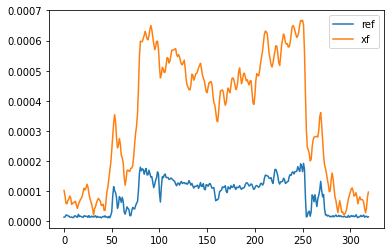

In [15]:
plt.figure()
plot_metric(results,'data_res_off',log=True)
plot_metric(results,'data_res_on',log=True)
plot_metric(results, 'reg_res',log=True)
plt.legend()


psnr = psnr_ssos(x,real_img,mask=square_mask)
ssim = ssim_ssos(x,real_img,mask=square_mask)
plt.figure()
implot(ssos(x),title=f"PSNR = {psnr:.2f} dB, ssim={ssim:.3f}",mask=square_mask, colorbar=True);


plt.figure()
plt.plot(abs(real_img[320]),label='ref')
plt.plot(abs(ssos(x)[320]),label='xf')
plt.legend()